# CS224N Assignment 1: Exploring Word Vectors (25 Points)

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. 

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

In [2]:
with open("lavoz.corpus") as f:
    news = list(f)

Let's have a look what these documents are like….

In [3]:
import nltk.tokenize
from pprint import pprint

#print(news[0])
def tokenize(text):

    tokens = nltk.tokenize.word_tokenize(text, language='spanish')
    tokens = [t.lower() for t in tokens if t[0].isalpha()]
    
    return tokens

pprint(tokenize(news[0])[:200], compact=True)

['la', 'ex', 'ministra', 'de', 'salud', 'graciela', 'ocaña', 'solicitará',
 'esta', 'semana', 'a', 'la', 'justicia', 'federal', 'desarchivar', 'una',
 'denuncia', 'por', 'supuestas', 'facturas', 'apócrifas', 'que', 'tendrían',
 'relación', 'colateral', 'con', 'la', 'causa', 'de', 'la', 'mafia', 'de',
 'los', 'medicamentos', 'la', 'presentación', 'de', 'ocaña', 'en', 'los',
 'tribunales', 'porteños', 'podría', 'salpicar', 'a', 'empresas', 'del', 'ramo',
 'en', 'córdoba', 'el', 'pedido', 'se', 'sustentará', 'en', 'la', 'presunción',
 'de', 'que', 'puede', 'haber', 'elementos', 'que', 'permitan', 'avanzar', 'en',
 'la', 'investigación', 'en', 'las', 'nuevas', 'escuchas', 'telefónicas', 'que',
 'agregó', 'el', 'juez', 'federal', 'norberto', 'oyarbide', 'a', 'la', 'causa',
 'que', 'tiene', 'a', 'su', 'cargo', 'en', 'noviembre', 'pasado', 'ocaña',
 'ministra', 'de', 'salud', 'del', 'gobierno', 'de', 'cristina', 'fernández',
 'entre', 'diciembre', 'de', 'y', 'junio', 'de', 'pidió', 'al', 'fis

In [4]:
tokenized_news = [tokenize(n) for n in news]

In [5]:
import pandas as pd

counter = {}

for doc in tokenized_news:
    for tok in doc:
        counter[tok] = counter.get(tok, 0) + 1


In [6]:
words = pd.Series(counter)

¿Cuántas quedan con más de 3 ocurrencias?

[]

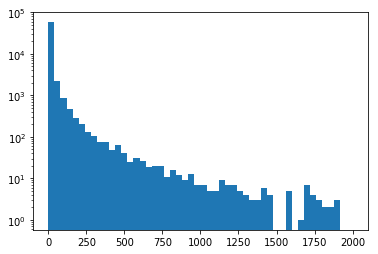

In [7]:
import matplotlib.pyplot as plt

plt.hist(words, range=(0, 2000), bins=50)

plt.semilogy()

In [8]:
sum(words > 3)

25414

In [9]:
relevant_words = words[words > 3].index
word2Ind = {word:k for k, word in enumerate(relevant_words)}

num_words = len(relevant_words)

print("Nos quedamos con ", num_words)

Nos quedamos con  25414


In [10]:
%%time
window_size = 5
# ------------------
# Write your implementation here.

co_occ = {}

for doc in tokenized_news:
    for center_idx, center_word in enumerate(doc):
        try:
            i = word2Ind[center_word]
        except KeyError:
            continue
        for context_word in doc[max(center_idx-window_size, 0):center_idx+window_size+1]:
            try:
                j = word2Ind[context_word]
            except KeyError:
                continue
            if i != j:
                co_occ[(i, j)] = co_occ.get((i, j), 0)+ 1

CPU times: user 23.5 s, sys: 276 ms, total: 23.8 s
Wall time: 23.8 s


In [11]:
from scipy.sparse import dok_matrix

M = dok_matrix((num_words, num_words))

for coords, value in co_occ.items():
    M[coords] = value

In [12]:
M = M.tocsr()

In [22]:
from sklearn.decomposition import TruncatedSVD
""" Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
    to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
        - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

    Params:
        M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
        k (int): embedding size of each word after dimension reduction
    Return:
        M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                In terms of the SVD from math class, this actually returns U * S
"""    
n_iters = 30     # Use this parameter in your call to `TruncatedSVD`

svd = TruncatedSVD(n_components=60, n_iter=n_iters)
print("Running Truncated SVD over %i words..." % (M.shape[0]))

svd.fit(M)

M_reduced = svd.transform(M)
print("Done.")

Running Truncated SVD over 25414 words...
Done.


In [23]:
M_norm = M_reduced / np.linalg.norm(M_reduced, axis=1).reshape(-1, 1)

In [29]:
def closest_words(palabra, num_words=20):
    if isinstance(palabra, str):
        orig_idx = word2Ind[palabra]
        vec = M_norm[orig_idx]
    else:
        vec = palabra

    cos_sim = (M_norm @ vec)

    best_indices = np.argsort(-cos_sim)[1:num_words+1]
    
    return [relevant_words[idx] for idx in best_indices]
    

for word in ["macri", "cristina", "izquierda", "derecha", "revolución",
             "francisco", "maradona", "matemática", "ciencia",
             "piqueteros", "inseguridad", "fútbol", "messi"
             "argentina", "uruguay", "china", "rusia", "eeuu"]:
    best_words = closest_words(word, num_words=10)
    print("="*80)
    print("Palabras más cercanas a {}\n".format(word))
    for i, close_word in enumerate(best_words):
        print("{:>2}. {}".format(i+1, close_word))
    


Palabras más cercanas a macri

 1. salió
 2. chávez
 3. irán
 4. mauricio
 5. sánchez
 6. quien
 7. rousseff
 8. cargo
 9. mubarak
10. china
Palabras más cercanas a cristina

 1. fernández
 2. presidenta
 3. nadia
 4. kirchner
 5. michelle
 6. elisa
 7. electa
 8. moyano
 9. néstor
10. fortuna
Palabras más cercanas a izquierda

 1. educación
 2. salud
 3. producción
 4. seguridad
 5. gravedad
 6. venta
 7. compra
 8. economía
 9. recolección
10. voluntad
Palabras más cercanas a derecha

 1. mundial
 2. industria
 3. propiedad
 4. juventud
 5. revolución
 6. cultura
 7. social
 8. economía
 9. estabilidad
10. unidad
Palabras más cercanas a revolución

 1. organización
 2. industria
 3. jerarquía
 4. legalidad
 5. unidad
 6. cámara
 7. nación
 8. ilusión
 9. recuperación
10. brigada
Palabras más cercanas a francisco

 1. jesús
 2. lorenzo
 3. maría
 4. belgrano
 5. dolores
 6. tercero
 7. jardín
 8. pablo
 9. carlos
10. santa
Palabras más cercanas a maradona

 1. allegados
 2. vice
 3. l

KeyError: 'messiargentina'

## Búsqueda de analogías

In [25]:
x = M_norm[word2Ind["fútbol"]]
y = M_norm[word2Ind["messi"]]
z = M_norm[word2Ind["finanzas"]]

closest_words(z+y-x)

['profesionalización',
 'definidas',
 'rendiciones',
 'autorizaciones',
 'lentes',
 'cortinas',
 'suspendidas',
 'atenderlas',
 'exento',
 'experiencias',
 'renegó',
 'garantías',
 'convocatorias',
 'cubrirse',
 'cocheras',
 'lecciones',
 'señalización',
 'angeli',
 'asociaciones',
 'afecciones']

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [ ]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [ ]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=[], negative=[]))

# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [ ]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=[], negative=[]))

# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

#### <font color="red">Write your answer here.</font>

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (2 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=[], negative=[]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[,], negative=[]))

# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.8: Thinking About Bias [written] (1 point)

What might be the cause of these biases in the word vectors?

#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your SUNET ID above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
7. Submit your PDF on Gradescope.